<a href="https://colab.research.google.com/github/Felipe0Parra/IO/blob/main/Paulina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difracción discreta por metodo de la propagación del espectro angular

### Librerías

In [ ]:
import numpy as np
import scipy as sp
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
import imageio
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

from PIL import Image

u = pint.UnitRegistry()

## Funciones auxiliares:

In [ ]:
def select_cmap_for_wavelength(wavelength_nm):
    """
    Selecciona un cmap adecuado basado en la longitud de onda.

    Parámetro:
        wavelength_nm (float): Longitud de onda en nanómetros (nm)

    Retorno:
        str: Nombre del cmap para el rango de longitud de onda
    """
    if wavelength_nm < 450:
        color_violeta = [(0, 0, 0),
                         (50/250, 0, 50/250),
                         (100/250, 0, 100/250),
                         (150/250, 0, 150/250),
                         (200/250, 0, 200/250),
                         (250/250, 0, 250/250)]
        return color_violeta

    elif 450 <= wavelength_nm < 495:
        color_azul = [(0, 0, 0),
                      (0, 0, 50/250),
                      (0, 0, 100/250),
                      (0, 0, 150/250),
                      (0, 0, 200/250),
                      (0, 0, 250/250)]
        return color_azul   # Azul

    elif 495 <= wavelength_nm < 570:
        color_verde = [(0, 0, 0),
                       (0, 50/250, 0),
                       (0, 100/250, 0),
                       (0, 150/250, 0),
                       (0, 200/250, 0),
                       (0, 250/250, 0)]
        return color_verde   # Verde

    elif 570 <= wavelength_nm < 590:
        color_naranja = [(0, 0, 0),
                       (50/250, 50/250, 0),
                       (100/250, 100/250, 0),
                       (150/250, 150/250, 0),
                       (200/250, 200/250, 0),
                       (250/250, 250/250, 0)]
        return color_naranja  # Naranja

    elif 590 <= wavelength_nm:
        color_rojo = [(0, 0, 0),
                       (50/250, 0, 0),
                       (100/250, 0, 0),
                       (150/250, 0, 0),
                       (200/250, 0, 0),
                       (250/250, 0, 0)]
        return color_rojo     # Rojo Claro

    else:
        return color_rojo # Rojo Oscuro para >620 nm

In [ ]:
def normalize_image(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

In [ ]:
def intensidad_del_campo(campo):
    intensidad_espectro_imagen = np.abs(campo)**2
    return intensidad_espectro_imagen

## Campo indicente

El campo incidente corresponde a una onda plana monocromatica o policromatica bien se desee, que incide sobre una transmitancia binaria. Por lo cual, una onda plana incidente de amplitud normalizada se puede representar directamente por la transmitancia binaria, dado que son la multplicación de la onda plana y la matriz con las ranuras.

Se puede ademas mostrar que el campo total se forma a partir de la suma de los campos de ranuras individuales:

## Abertura tipo anillo

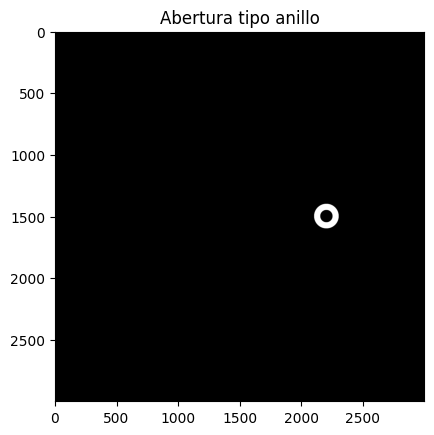

In [ ]:
anillo = np.zeros((3000, 3000))

R_1 = 50 # Radio menor en pixeles
R_2 = 100 # Radio mayor en pixeles
centro = (2200, 1500)  # Zona en pixeles desde la esquina sup/izq e inf/izq en la que se centran los circulos.

cv2.circle(anillo, centro, R_2, 1, -1)
cv2.circle(anillo, centro, R_1, 0, -1)

plt.imshow(anillo, cmap = 'gray')
plt.title('Abertura tipo anillo')
plt.show()

## Abertura tipo rectangulo

Se debe garantizar que todas las matrices tengan el mismo tamaño y dimensiones.

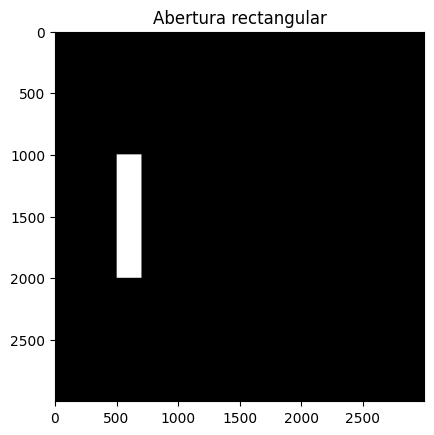

In [ ]:
rectangulo = np.zeros((3000, 3000))

esquina_1 = (500, 1000)    # Posición (Horizontal, Vertical) de la esquina superior izquierda.
esquina_2 = (700, 2000)   # Posición (Horizontal, Vertical) de la esquina inferior derecha.

# Por lo cual, las dimensiones son:
a = np.abs(esquina_2[0] - esquina_1[0])
b = np.abs(esquina_1[1] - esquina_2[1])

cv2.rectangle(rectangulo, esquina_1, esquina_2, 1, -1)

plt.imshow(rectangulo, cmap = 'gray')
plt.title('Abertura rectangular')
plt.show()

Claramente la distancia D entre los centros de las figuras corresponde a:

In [ ]:
D = np.abs((esquina_2[0] - esquina_1[0]) - centro[0])
print(f"Distancia entre los centros de las figuras: {D} pixeles")

Distancia entre los centros de las figuras: 2000 pixeles


## Campo inicial completo:

Sumando las matrices de las aberturas individuales:

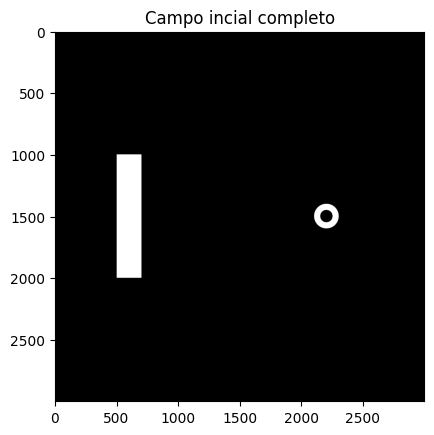

In [ ]:
U_0 = anillo + rectangulo

plt.imshow(U_0, cmap = 'gray')
plt.title('Campo incial completo')
plt.show()

## Propagación por el espectro angular

Definimos las dimensiones físicas realistas del plano de la abertura:

In [ ]:
xp = np.shape(U_0)[0]
yp = np.shape(U_0)[1]

l_planex = 4   # mm
l_planey = 4  # mm

x_pea = np.linspace(0, l_planex, xp)
y_pea = np.linspace(0, l_planey, yp)

xv_pea, yv_pea = np.meshgrid(x_pea, y_pea)

Definimos la longitud de onda a usar:

In [ ]:
lam = 550e-6  # mm

Definimos el algoritmo de propagación del espectro angular:

In [ ]:
def compute_A(UT, xv, yv, lam, z):
    A = fft2(UT)         # Campo U
    kx = 2 * np.pi * fftfreq(len(x_pea), np.diff(x_pea)[0])
    ky = 2 * np.pi * fftfreq(len(y_pea), np.diff(y_pea)[0])
    kxv, kyv = np.meshgrid(kx, ky)
    k = 2 * np.pi/lam
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))

Elegimos una distancia de propagación apropiada, para la condición de campo lejano:

In [ ]:
z_pea = 50

Ejecutamos el algoritmo aplicado al campo de la ranura completa, a la distancia y longitud de onda elegidas.

In [ ]:
U = compute_A(U_0, xv_pea, yv_pea, lam, z_pea)

Mostramos el patrón de difracción proyectado en el plano de observación:

In [ ]:
wavelength = int(lam * 1e6) # Longitud de onda en nanómetros
cmap = select_cmap_for_wavelength(wavelength)
cmap_spectrum = LinearSegmentedColormap.from_list("spectrum", cmap, N=256)

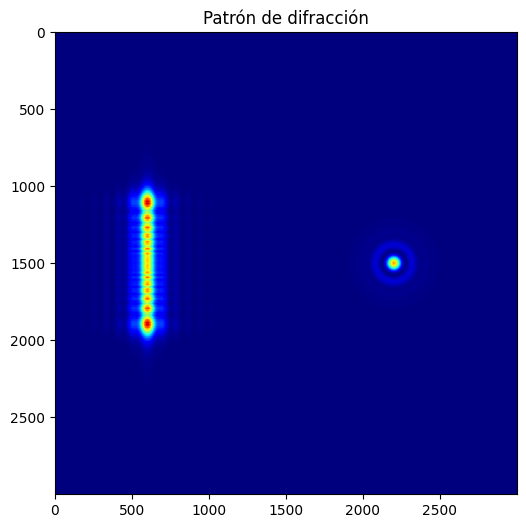

In [ ]:
U_f = normalize_image(intensidad_del_campo(U))

plt.figure(figsize=(6,6))
plt.imshow(U_f, cmap = 'jet')
plt.title('Patrón de difracción')
plt.show()

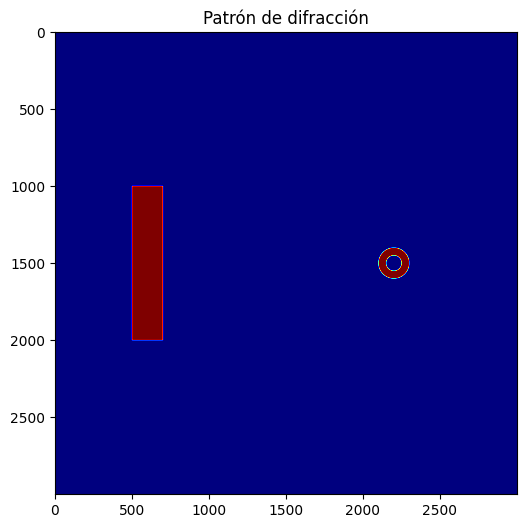

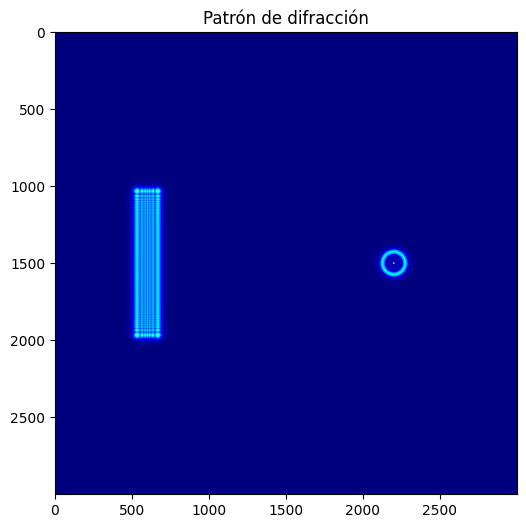

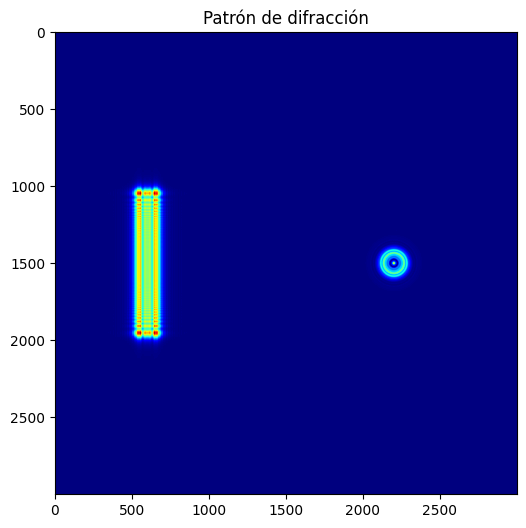

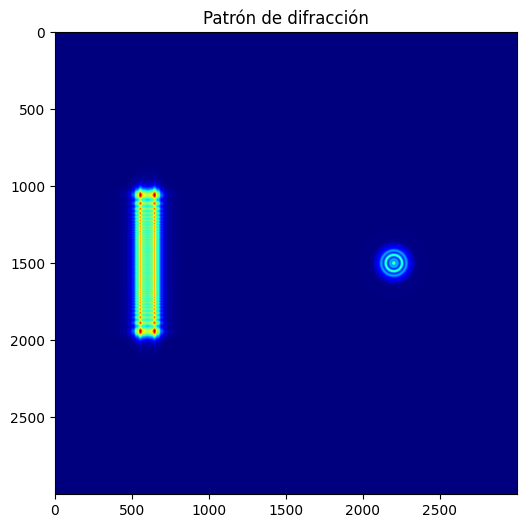

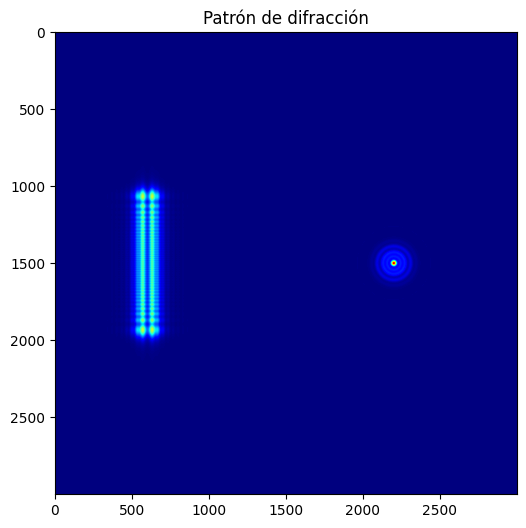

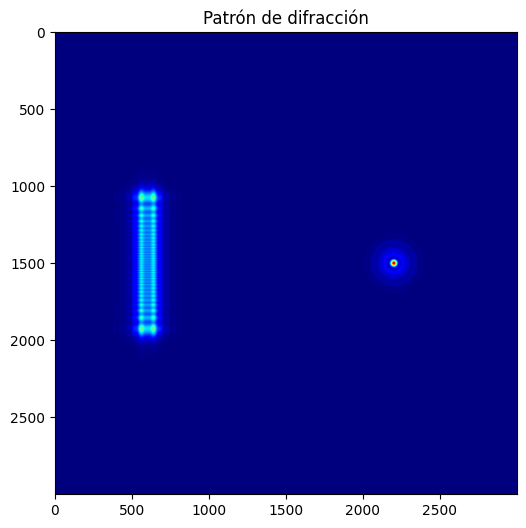

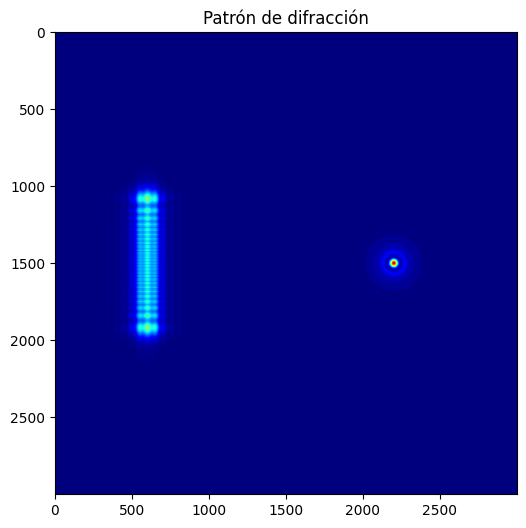

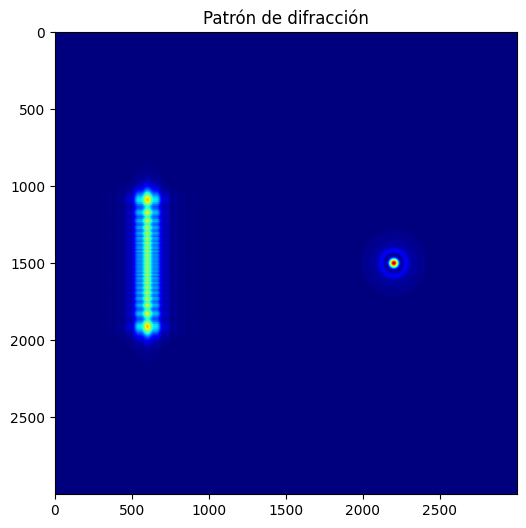

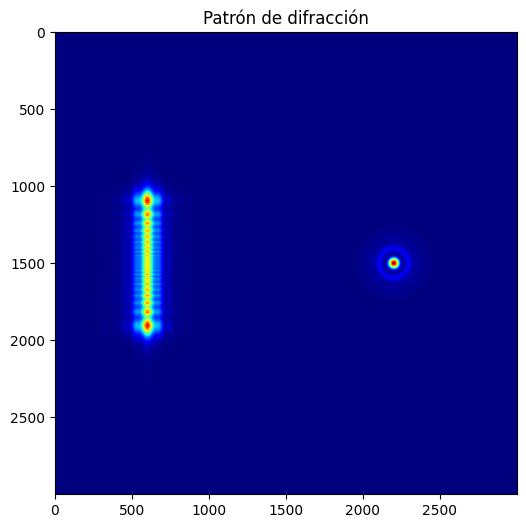

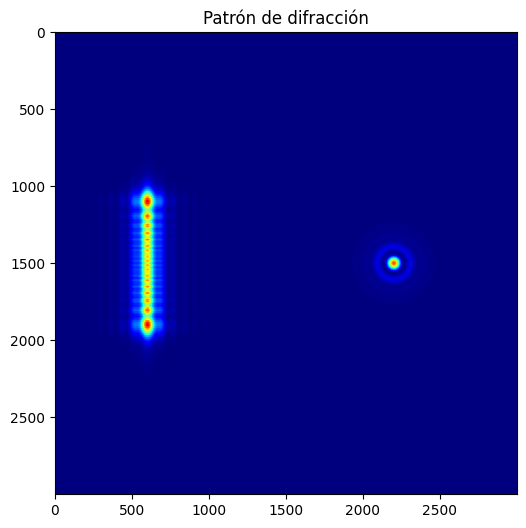

In [ ]:
for z_imgs in range(0, 50, 5):
    U = compute_A(U_0, xv_pea, yv_pea, lam, z_imgs)
    U_fr = normalize_image(intensidad_del_campo(U))
    plt.figure(figsize=(6,6))
    plt.imshow(U_fr, cmap = 'jet')
    plt.title('Patrón de difracción')
    plt.show()

Es importante tener en cuenta el criterio de campo lejano, que es cuando realmente se muestra el patrón de Fraunhofer, el metodo del espectro angular es valido para regiones de campo lejano y de campo cercano, pero el campo lejano se evidencia cuando el factor de fase cuadratico que sale de Rayleigh-Sommerfeld no aporta oscilaciones signficativas hacia el interior de la abertura principalmente. Es decir, el regimen de Fraunhofer se visualiza cuando el patrón de difracción no cambia de forma sino solo de tamaño. Recordando que la luz en el espacio se propaga como una onda esferica divergente.